# Bước 1: Import Modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from io import BytesIO
import pandas as pd
import numpy as np
import requests
np.random.seed(0)
plt.style.use("ggplot")
import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.6.0
GPU detected: []


# Bước 2: Load bộ dữ liệu NER

Thông tin các thực thể:

geo = Geographical Entity\
org = Organization\
per = Person\
gpe = Geopolitical Entity\
tim = Time indicator\
art = Artifact\
eve = Event\
nat = Natural Phenomenon

Sau khi đọc tập dữ liệu, chúng ta quan sát thử 50 dòng đầu tiên như thế nào.


In [3]:
data = pd.read_csv('/content/drive/MyDrive/Dataset/ner_dataset.csv',encoding="latin1")
data = data.fillna(method="ffill")
data.head(30)


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


#Visualizing the Sentenceentence
Thông kê bộ dữ liệu:
- Số lượng từ duy nhất trong kho ngữ liệu. (Tập từ vựng, số chiều)
- Số lượng thẻ duy nhất trong tập dữ liệu. (Tập nhãn)


Bằng cách sử dụng hàm **“nunique”.**

In [4]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 35178
Unique tags in corpus: 17


Tạo một danh sách và sử dụng phương thức set() để lấy các giá trị trong cột “word” và loại bỏ giá trị trùng.\
Thêm phần đệm có tên “Endpad”.


In [5]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

In [6]:
print(words)
print(num_words)

['boats', 'Suspected', 'Inheritance', 'Roberts', 'Hawiye', 'Schroeder', 'Lutfi', '2.3', 'Once', 'bats', 'Wael', 'air', 'site', 'facts', '32.7', 'GUEI', 'Abdul-Khalim', 'Tekunan', 'jockeys', 'follower', 'Abdurahman', 'Councilor', 'kept', 'Veligonda', 'February', 'zookeepers', 'specter', 'Megumi', 'sea-based', 'Ellison', 'lent', 'Batticaloa', 'pre-emptive', 'athletic', '0.04', 'al-Hafidh', 'Sagaing', 'country', 'wanted', 'Harbor', 'Nazif', 'nuns', 'shoving', 'Zealand', 'blanked', 'soils', 'Champions', 'road-trip', 'Allah', 'rejecting', 'Burge', 'Qasr', 'Genro', 'anti-insurgent', 'Colombant', 'Chinooks', 'Breast', 'dwarfed', 'rabbi', 'Kenyans', 'aimed', 'elements', 'Japan', '44-yard', 'Alexy', 'generic', 'Kerry', 'mingle', 'relaunch', 'mid-1999', '104', 'summit', 'responding', 'traveling', 'mid-November', 'pro-Pakistani', 'overthrown', 'Disease', 'oxygen', 'Jabr', 'spokeswoman', 'firehouses', 'bowling', 'thing', 'Khormato', 'synagogue', 'laptops', 'Daniel', 'oceans', 'locomotives', 'Cesme

In [7]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)

In [8]:
print(tags)
print(num_tags)

['B-per', 'I-eve', 'I-per', 'B-org', 'I-tim', 'B-art', 'I-gpe', 'I-nat', 'B-nat', 'B-gpe', 'B-tim', 'B-eve', 'O', 'I-art', 'I-geo', 'I-org', 'B-geo']
17


In [9]:
print(num_words, num_tags)

35179 17


# Bước 3: Lấy các câu và các thẻ tương ứng

In [10]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

#các bạn có thể viết theo cách khác

In [11]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [12]:
sentences[1]

[('Iranian', 'JJ', 'B-gpe'),
 ('officials', 'NNS', 'O'),
 ('say', 'VBP', 'O'),
 ('they', 'PRP', 'O'),
 ('expect', 'VBP', 'O'),
 ('to', 'TO', 'O'),
 ('get', 'VB', 'O'),
 ('access', 'NN', 'O'),
 ('to', 'TO', 'O'),
 ('sealed', 'JJ', 'O'),
 ('sensitive', 'JJ', 'O'),
 ('parts', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('the', 'DT', 'O'),
 ('plant', 'NN', 'O'),
 ('Wednesday', 'NNP', 'B-tim'),
 (',', ',', 'O'),
 ('after', 'IN', 'O'),
 ('an', 'DT', 'O'),
 ('IAEA', 'NNP', 'B-org'),
 ('surveillance', 'NN', 'O'),
 ('system', 'NN', 'O'),
 ('begins', 'VBZ', 'O'),
 ('functioning', 'VBG', 'O'),
 ('.', '.', 'O')]

# Bước 4: Ánh xạ giữa các câu và chỉ mục
Chúng ta có thể thấy rằng mỗi từ được gán cho một thẻ duy nhất. Chúng tôi có thể truy xuất những từ này bằng cách sử dụng các chỉ số của chúng và tra cứu chúng trong từ điển và trả về các khóa tương ứng.


In [13]:
word2idx = {w: i   for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [14]:
# word2idx
# word2idx["ENDPAD"]
tag2idx 

{'B-art': 5,
 'B-eve': 11,
 'B-geo': 16,
 'B-gpe': 9,
 'B-nat': 8,
 'B-org': 3,
 'B-per': 0,
 'B-tim': 10,
 'I-art': 13,
 'I-eve': 1,
 'I-geo': 14,
 'I-gpe': 6,
 'I-nat': 7,
 'I-org': 15,
 'I-per': 2,
 'I-tim': 4,
 'O': 12}

#Bước 5: Padding  đầu vào và cắt dữ liệu thành tập Train/Test\
Trong trục X, có thể thấy độ dài an toàn của câu là khoảng 50.

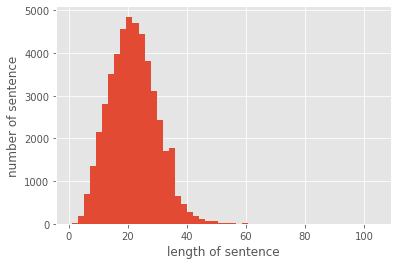

In [15]:
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel("length of sentence")
plt.ylabel('number of sentence')
plt.show()

- Sử dụng hàm pad_sequence() cho padding
- X sẽ là một đại diện bằng số cho các từ. (sử dụng word2idx)
- ‘Post’ chỉ là một giá trị của đối số đệm ở cuối câu.
- X,y là vector

In [18]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len = 50
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)
y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [19]:
print(X[0])
print(y[0])

[13788 29379 28455  7773  7664 23723  7146 34927 22380 16652 18426 31563
 10869   129 35060 16652  7604 29379 27300 14485 21070 27172    37  6232
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178]
[12 12 12 12 12 12 16 12 12 12 12 12 16 12 12 12 12 12  9 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12]


- test_size = 0.2 có nghĩa là 80% dữ liệu chia cho tập huấn luyện và 20% còn lại cho tập kiểm tra.

In [20]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Bước 6: Xây dựng Mô hình LSTM hai chiều (bi-LSTM)


In [21]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

Bản tóm tắt cho thấy rằng chúng ta có hơn 1,88 triệu tham số cần được huấn luyện.

In [22]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


- Sử dụng trình tối ưu hoá "adam"
- sparce_categorical_crossentropy làm hàm mất mát
- Ma trận mà chúng ta sẽ quan tâm là ma trận độ chính xác.

In [23]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

#Bước7: Huấn luyện Model

- Để bắt đầu huấn luyện là gọi model.fit ()
- Có thể tăng kích thước batch_size nếu bạn có GPU có kích thước bộ nhớ lớn.



In [24]:
# Các bạn nhớ là phải lưu mô hình khi train (có nhắc lại yêu cầu ở cuối) 
import time
start_time = time.time()

history = model.fit(
    x=x_train,
    y=y_train,
    # validation_data=(x_valid,y_valid),
    validation_split= 0.1,
    batch_size= 32, 
    epochs=1,
    verbose=1
)
print("[{}] Completed!".format(time.time() - start_time))

1080/1080 [==============================] - 199s 180ms/step - loss: 0.1954 - accuracy: 0.9554 - val_loss: 0.0725 - val_accuracy: 0.9799
[206.30957961082458] Completed!


# Bước8: Đánh giá mô hình NER



In [25]:
model.evaluate(x_test, y_test)

300/300 [==============================] - 7s 24ms/step - loss: 0.0753 - accuracy: 0.9797


[0.07526146620512009, 0.979716420173645]

- Dự đoán

In [26]:
# i = np.random.randint(0, x_test.shape[0]) #659
print(x_test[1])
i = 2
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

[ 1095  2315 15245 10837  3858 14004 21188  1209 20505 19280 14738 31012
 18576  7592 13317 14004 29160 12161  7592 18576  9797  9816 13301 28718
 15416 10711  6232  9816 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178]
Word           True 	 Pred

------------------------------
Black          O	O
unsavory       O	O
2              O	O
Kartli-Iberia  O	O
2015           O	O
Bo             O	O
perch          O	O
contry         B-geo	B-org
Number-eight   I-geo	I-geo
three-stage    O	O
liturgy        O	O
Makati         O	O
Bot            O	O
Townsend       B-tim	B-tim
97             O	O
divide-and-ruleO	O
divide-and-ruleO	O
divide-and-ruleO	O
divide-and-ruleO	O
divide-and-ruleO	O
divide-and-ruleO	O
divide-and-ruleO	O
divide-and-ruleO	O
divide-and-ruleO	O
divide-and-ruleO	O
divide-and-ruleO	O
divide-and-ruleO	O
divide-and-ruleO	O
divide-and-ruleO	O
divide-and-ruleO	O
divide-and-ruleO	O
divide-and-ruleO	O
div

In [27]:
# hoàn thành yêu cầu trong file thực hành tương ứng cho câu 1 và 2.